# PeakSwift: Analysis of Accuracy through Comparison towards Neurokit

This notebook presents an analysis of the PeakSwift package's capabilities in detecting R-peaks and assessment of signal quality within single-lead electrocardiogram signals. The evaluation is conducted against the established gold standard, NeuroKit. The analysis encompasses the thorough assessment and validation of the following key aspects:

- Accuracy of R-peak detection
- Performance in signal quality assessment
- Computational runtime efficiency

Through this analysis, we aim to provide a deeper understanding of the PeakSwift package's utility and effectiveness in comparison to a recognized standard. Additionally, the computational runtime is scrutinized to gauge the efficiency of the package in real-world applications.

In [1]:
import glob
import json
import time
from tqdm import tqdm
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import neurokit2 as nk
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Data Loading

The JSON-formatted exported data from the PeakWatch demo application must be located within the './data' directory.

In [2]:
files = glob.glob("./data/*.json")
df = pd.DataFrame()
events = pd.DataFrame()
for k in files:
    f = json.load(open(k))
    df = pd.concat([df, pd.json_normalize(f['ecgs'])])
df = df.reset_index()

Every row within the dataset corresponds to a 30-second electrocardiogram (ECG) recording, indicated in the 'ecg.ecg' column. Accompanying this primary data are essential metadata, including bpm, sampling rate, and date of recording. Additionally, PeakSwift's computed properties are included:

- R-peaks, computed through eight distinct detection algorithms
- Signal quality assessment, performed by two distinct algorithms

In [3]:
df.head(3)

,index,signal_quality,algorithms,device_id,apple_meta_data.recording_start_time,apple_meta_data.recording_endt_ime,apple_meta_data.beats_per_minute,apple_meta_data.software_version,apple_meta_data.hardware_version,apple_meta_data.source,apple_meta_data.device_name,apple_meta_data.manufacturer,apple_meta_data.algorithm_version,apple_meta_data.added_to_health_kit_date,apple_meta_data.model,apple_meta_data.apple_rating,ecg.ecg,ecg.sampling_rate
0,0,"[{'score': 'barelyAcceptable', 'method': 'Zhao...","[{'r_peaks': [], 'runtime': {'seconds': 0, 'at...",65D50EED-94AC-4AF5-9F57-051444996726,7.142375e+08,7.142375e+08,83,8.7,"Watch6,2",ECG,Apple Watch,Apple Inc.,2,7.142375e+08,Watch,Sinus rhytm,"[-1.114211082458496e-07, 2.4354569613933563e-0...",512
1,1,"[{'score': 'excellent', 'method': 'Zhao2018Sim...","[{'r_peaks': [147, 567, 995, 1419, 1831, 2262,...",65D50EED-94AC-4AF5-9F57-051444996726,7.142280e+08,7.142280e+08,76,8.7,"Watch6,2",ECG,Apple Watch,Apple Inc.,2,7.142280e+08,Watch,Sinus rhytm,"[-0.00010169728088378906, -9.53637466430664e-0...",512
2,2,"[{'score': 'unacceptable', 'method': 'Zhao2018...","[{'r_peaks': [182, 561, 908, 1236, 1550, 1902,...",65D50EED-94AC-4AF5-9F57-051444996726,7.141502e+08,7.141503e+08,96,8.7,"Watch6,2",ECG,Apple Watch,Apple Inc.,2,7.141503e+08,Watch,Sinus rhytm,"[2.2180131912231444e-05, 3.100137329101562e-05...",512


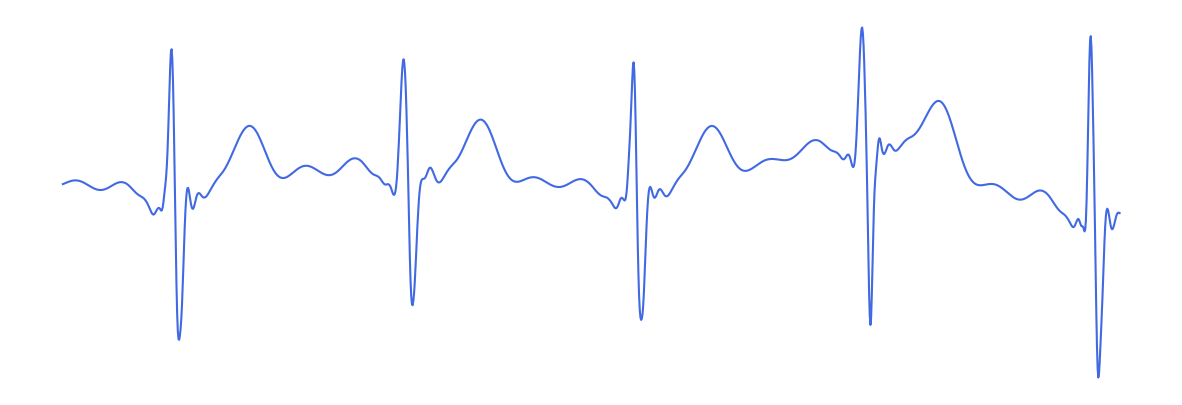

In [4]:
plt.figure(figsize=(15, 5))
plt.plot(df['ecg.ecg'][43][2000:3536], c='royalblue')
plt.axis('off')
plt.savefig('./results/sample_ecg.png', dpi=300)
#plt.close()

### Functions and Tools for Evaluation

Mapping from PeakSwift's to NeuroKit's Algorithm Naming Convention

In [5]:
algorithm_conversion_peak = {
    'Christov': 'christov',
    'Two Average': 'elgendi',
    'NeuroKit': 'neurokit',
    'Hamilton': 'hamilton',
    'Pan Tompkins': 'pantompkins',
    'Kalidas': 'kalidas',
    'Engzee': 'engzee',
    'Nabian': None,
    'Basic': None,
    'Aristotle': None,
    'WQRS': None,
    'UNSW': None,
}

algorithm_conversion_clean = {
    'christov': 'christov',
    'elgendi': 'elgendi2010',
    'neurokit': 'neurokit',
    'hamilton': 'hamilton2002',
    'pantompkins': 'pantompkins1985',
    'engzee': 'engzeemod2012',
    'kalidas': 'kalidas',
    'nabian': None,
    'Basic': None,
    'Aristotle': None,
    'UNSW': None,
    'WQRS': None,
}

In [6]:
def closest_value(arr, value):
    """
    Find the value in an array 'arr' that is closest to the given 'value'.
    """
    return arr[np.argmin(np.abs(arr - value))]

def mapped_mae(arr1, arr2, threshold_low=0, threshold_up=1000000000):
    """
    Calculate the mapped Mean Absolute Error (MAE) between two arrays 'arr1' and 'arr2',
    with optional lower and upper thresholds for error calculation.
    """
    total_mae = 0
    
    shorter_arr = arr1 if len(arr1) < len(arr2) else arr2
    longer_arr = arr2 if len(arr1) < len(arr2) else arr1
    
    for val1 in shorter_arr:
        closest_val2 = closest_value(longer_arr, val1)
        abs_diff = np.abs(val1 - closest_val2)
        if threshold_low <= abs_diff <= threshold_up:
            total_mae += abs_diff
    
    if len(shorter_arr) == 0:
        return 0
    
    return total_mae / len(shorter_arr)

def mae(arr1, arr2, threshold_low=0, threshold_up=100000000000):
    """
    Calculate the Mean Absolute Error (MAE) between two arrays 'arr1' and 'arr2',
    with optional lower and upper thresholds for error calculation.
    """
    abs_diffs = np.abs(arr1 - arr2)
    abs_diffs[(abs_diffs <= threshold_low) | (abs_diffs >= threshold_up)] = 0
    return np.mean(abs_diffs)

In [7]:
def compare_algorithm(signal, method, result_swift, sampling_rate=512, index=None, plot=False):
    
    """
    Compare R-peak detection algorithms and visualize the results.

    Parameters:
    signal (array-like): ECG signal.
    method (str, optional): R-peak detection method (default: 'neurokit').
    result_swift (array-like): Detected R-peaks from Swift algorithm.
    sampling_rate (int, optional): Sampling rate of the signal (default: 512).
    index (int): Index of the signal.
    plot (bool): Whether to plot the comparison.

    Returns:
    dict: Dictionary containing comparison results.
    """

    start = time.time()
    if method != 'nabian':
        cleaned_signal = nk.ecg_clean(signal, sampling_rate, method=algorithm_conversion_clean[method])
    else:
        cleaned_signal = signal
    end = time.time()
    time_cleaning = (end - start)

    start = time.time()
    
    result_nk = nk.ecg_peaks(cleaned_signal, sampling_rate, method)
    end = time.time()
    time_rPeak_detection = (end - start)
    result_nk = np.where(result_nk[0]['ECG_R_Peaks'] > 0)[0]
    
    if plot:
        plt.figure(figsize=(60, 5))
        plt.plot(signal, c='red', label='Original Signal')
        plt.vlines(
            x=result_swift, colors='blue',
            ymin=np.min(signal), ymax=np.max(signal),
            label='Swift: Detected ' + str(len(result_swift)) +  ' R-peaks with ' + method,
        )
        plt.vlines(
            x=result_nk, colors='green',
            ymin=np.min(signal), ymax=np.max(signal),
            label='Python: Detected ' + str(len(result_nk)) + ' R-peaks with ' + method,
        )
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
        plt.title('Comparison of R-peak Detection')
        plt.legend()
        plot_filename = f'./results/{index}_{method}.png'
        plt.savefig(plot_filename, dpi=300)
        plt.close()

    number_r_peaks_swift = len(result_swift)
    number_r_peaks_neurokit = len(result_nk)
    
    if (number_r_peaks_swift == number_r_peaks_neurokit):
        mean_difference_t0 = mae(result_nk, result_swift)
        mean_difference_t1 = mae(result_nk, result_swift, 1)
        mean_difference_t5 = mae(result_nk, result_swift, 5)
        mean_difference_t10 = mae(result_nk, result_swift, 200)
    else:
        mean_difference_t0 = np.nan
        mean_difference_t1 = np.nan
        mean_difference_t5 = np.nan
        mean_difference_t10 = np.nan

    mean_difference_mapped_t0 = mapped_mae(result_nk, result_swift)
    mean_difference_mapped_t1 = mapped_mae(result_nk, result_swift, 1)
    mean_difference_mapped_t5 = mapped_mae(result_nk, result_swift, 5)
    mean_difference_mapped_t10 = mapped_mae(result_nk, result_swift, 10)
    
    result = {
        'mean_difference_t0': mean_difference_t0,
        'mean_difference_t1': mean_difference_t1,
        'mean_difference_t5': mean_difference_t5,
        'mean_difference_t10': mean_difference_t10,
        'mean_difference_mapped_t0': mean_difference_mapped_t0,
        'mean_difference_mapped_t1': mean_difference_mapped_t1,
        'mean_difference_mapped_t5': mean_difference_mapped_t5,
        'mean_difference_mapped_t10': mean_difference_mapped_t10,
        'bpm_swift': number_r_peaks_swift * 2,
        'number_r_peaks_swift': number_r_peaks_swift,
        'number_r_peaks_neurokit': number_r_peaks_neurokit,
        'runtime_m1_cleaning': time_cleaning,
        'runtime_m1_rPeak_detection': time_rPeak_detection,
    }
    
    return result

In [8]:
def process_row(row, algorithm_conversion_peak, index, plot=False):
    signal = np.array(row['ecg.ecg'])
    sampling_rate = row['ecg.sampling_rate']
    bpm_apple = row['apple_meta_data.beats_per_minute']
    
    quality_neurokit_simple = np.nan
    quality_peakswift_simple = np.nan
    quality_neurokit_fuzzy = np.nan
    quality_peakswift_fuzzy = np.nan
    
    for quality in row.signal_quality:
        if quality['method'] == 'Zhao2018Simple':
            quality_neurokit_simple = nk.ecg_quality(signal, method='zhao2018', approach='simple', sampling_rate=sampling_rate)
            quality_peakswift_simple = quality['score']
        elif quality['method'] == 'Zhao2018Fuzzy':
            quality_neurokit_fuzzy = nk.ecg_quality(signal, method='zhao2018', approach='fuzzy', sampling_rate=sampling_rate)
            quality_peakswift_fuzzy = quality['score']
        else:
            print('sth went wrong')
            
    quality_apple = row['apple_meta_data.apple_rating']
    
    result_rows = []
    
    identifier = row['device_id']
    device = row['apple_meta_data.hardware_version']
    
    for algo_info in row.algorithms:
        algo_name = algo_info['algorithm']
        algorithm = algorithm_conversion_peak.get(algo_name)
        
        if algorithm is None:
            continue
        
        try:
            comparison = compare_algorithm(signal, algorithm, algo_info['r_peaks'], sampling_rate, index, plot)
        except Exception as error:
            print('Exception', identifier, algorithm, error)
            continue

        metadata = {
            'id': index,
            'device': device,
            'sampling_rate': sampling_rate,
            'signal_quality_neurokit_simple': quality_neurokit_simple,
            'signal_quality_neurokit_fuzzy': quality_neurokit_fuzzy,
            'signal_quality_swift_simple': quality_peakswift_simple,
            'signal_quality_swift_fuzzy': quality_peakswift_fuzzy,
            'signal_rating_apple': quality_apple,
            'algorithm': algorithm,
            'bpm_apple': bpm_apple,
            'runtime_swift': algo_info['runtime']['attoseconds'] / 1e+18,
        }

        result_rows.append({**metadata, **comparison})

    return result_rows

Loop through the dataframe and construct a result table by gathering benchmarking metrics.

In [9]:
result_rows = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    result_rows.extend(process_row(row, algorithm_conversion_peak, index, False))
result_table = pd.DataFrame(result_rows)
result_table.index = range(len(result_table))

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                   | 193/234 [00:41<00:08,  4.77it/s]

Exception 65D50EED-94AC-4AF5-9F57-051444996726 engzee pop from empty list


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:49<00:00,  4.70it/s]


In [10]:
result_table['bpm_difference'] = np.abs(result_table['bpm_apple'] - result_table['bpm_swift'])
result_table['peak_diff'] = result_table['number_r_peaks_neurokit'] - result_table['number_r_peaks_swift']

runtime_m1_total = result_table['runtime_m1_cleaning'] + result_table['runtime_m1_rPeak_detection']
runtime_diff = runtime_m1_total - result_table['runtime_swift']
result_table['runtime_difference'] = np.abs(runtime_diff)

In [11]:
result_table.head(5)

,id,device,sampling_rate,signal_quality_neurokit_simple,signal_quality_neurokit_fuzzy,signal_quality_swift_simple,signal_quality_swift_fuzzy,signal_rating_apple,algorithm,bpm_apple,...,mean_difference_mapped_t5,mean_difference_mapped_t10,bpm_swift,number_r_peaks_swift,number_r_peaks_neurokit,runtime_m1_cleaning,runtime_m1_rPeak_detection,bpm_difference,peak_diff,runtime_difference
0,0,"Watch6,2",512,Barely acceptable,Excellent,barelyAcceptable,excellent,Sinus rhytm,pantompkins,83,...,0.000000,0.0,84,42,42,0.000581,0.000604,1,0,0.016680
1,0,"Watch6,2",512,Barely acceptable,Excellent,barelyAcceptable,excellent,Sinus rhytm,engzee,83,...,0.000000,0.0,78,39,39,0.000743,0.056257,5,0,0.014907
2,0,"Watch6,2",512,Barely acceptable,Excellent,barelyAcceptable,excellent,Sinus rhytm,hamilton,83,...,0.000000,0.0,84,42,42,0.000514,0.006285,1,0,0.011354
3,0,"Watch6,2",512,Barely acceptable,Excellent,barelyAcceptable,excellent,Sinus rhytm,neurokit,83,...,0.000000,0.0,78,39,39,0.001097,0.000997,5,0,0.050078
4,0,"Watch6,2",512,Barely acceptable,Excellent,barelyAcceptable,excellent,Sinus rhytm,christov,83,...,0.972222,0.0,72,36,36,0.000031,0.125577,11,0,0.090449


### Signal Quality

In [12]:
def plot_confusion_matrix(
    groundtruth, prediction, labels,
    title, xlabel='PeakSwift', ylabel='Neurokit', x_rotation=0,
    save=False
):
    plt.close()
    cm = confusion_matrix(groundtruth, prediction, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    disp.ax_.set(title=title, xlabel = xlabel, ylabel = ylabel)
    plt.xticks(rotation=x_rotation)
    plt.show()
    if save:
        plt.savefig('./results/' + title + '.png')
    plt.close()

In [14]:
sq = result_table[
    [
        'id', 'signal_quality_neurokit_simple',
        'signal_quality_neurokit_fuzzy', 'signal_quality_swift_simple',
        'signal_quality_swift_fuzzy', 'signal_rating_apple',
    ]
].drop_duplicates('id')

In [15]:
labels = ['Excellent', 'Barely acceptable', 'Unacceptable']
labels_apple = ['Inconclusive poor reading', 'Sinus rhytm', 'Inconclusive']

In [16]:
# Neurokit returns a small spelling mistake: Unnacceptable
sq.signal_quality_neurokit_fuzzy = sq.signal_quality_neurokit_fuzzy.replace('Unnacceptable', 'Unacceptable')

In [17]:
sq.signal_quality_swift_simple = sq.signal_quality_swift_simple.replace('barelyAcceptable', 'Barely acceptable').replace('unacceptable', 'Unacceptable').replace('excellent', 'Excellent')
sq.signal_quality_swift_fuzzy = sq.signal_quality_swift_fuzzy.replace('barelyAcceptable', 'Barely acceptable').replace('unacceptable', 'Unacceptable').replace('excellent', 'Excellent')

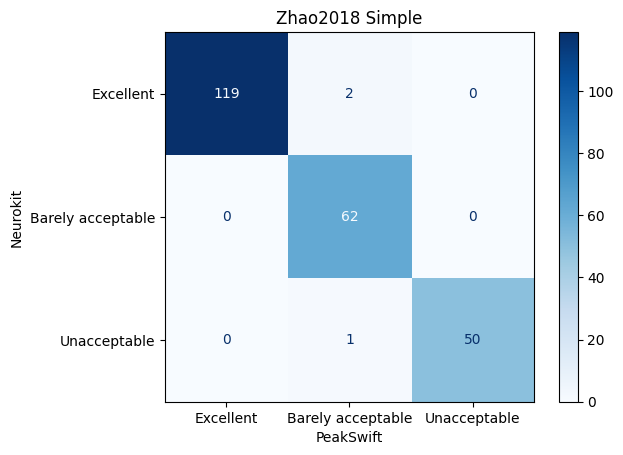

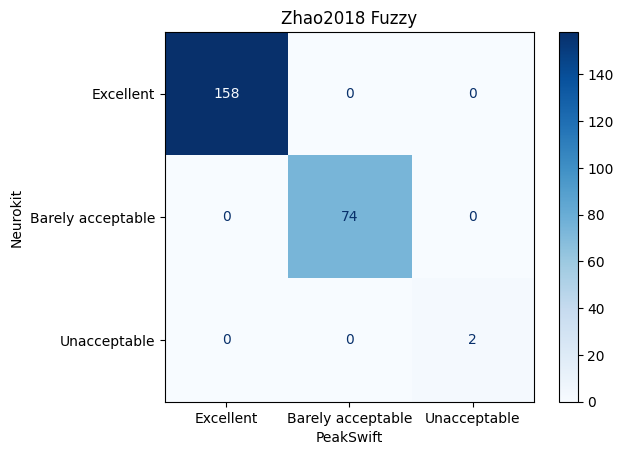

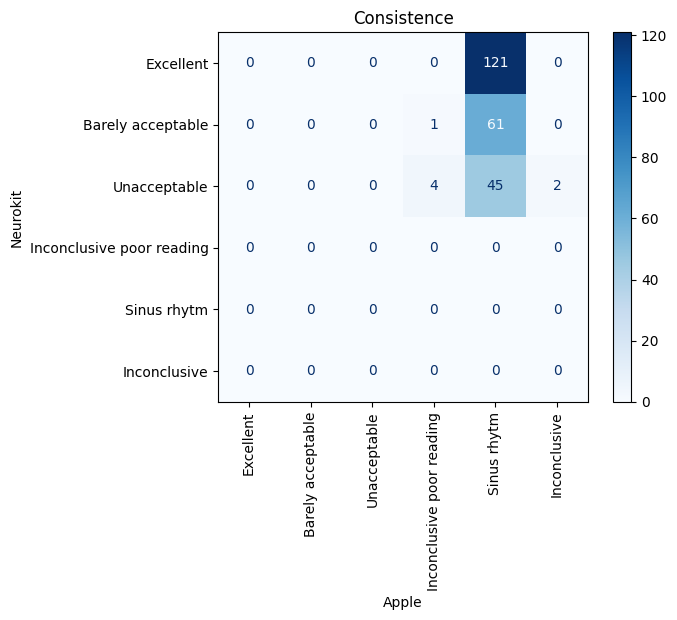

In [18]:
plot_confusion_matrix(
    sq.signal_quality_neurokit_simple, sq.signal_quality_swift_simple, labels,
    title="Zhao2018 Simple", save=True,
)
plot_confusion_matrix(
    sq.signal_quality_neurokit_fuzzy, sq.signal_quality_swift_fuzzy, labels,
    title="Zhao2018 Fuzzy", save=True,
)
plot_confusion_matrix(
    sq.signal_quality_neurokit_simple, sq.signal_rating_apple, labels + labels_apple,
    title="Consistence", xlabel='Apple', x_rotation=90, save=True,
)

### R-peak Detection Accuracy

In [19]:
evaluation_overview = result_table.groupby('algorithm')[
    ['mean_difference_t0', 'mean_difference_mapped_t0',
     'mean_difference_t1', 'mean_difference_mapped_t1',
     'mean_difference_t5', 'mean_difference_mapped_t5',
     'mean_difference_t10', 'mean_difference_mapped_t10',
     'runtime_difference'
    ]
].agg(['mean'])

In [20]:
evaluation_overview

,mean_difference_t0,mean_difference_mapped_t0,mean_difference_t1,mean_difference_mapped_t1,mean_difference_t5,mean_difference_mapped_t5,mean_difference_t10,mean_difference_mapped_t10,runtime_difference
,mean,mean,mean,mean,mean,mean,mean,mean,mean
algorithm,,,,,,,,,
christov,2.196630,7.340118,1.692678,7.340118,1.023262,6.447964,0.000000,6.058779,0.052996
elgendi,0.022809,0.022809,0.022331,0.022809,0.022331,0.022331,0.000000,0.022331,0.036443
engzee,0.042581,0.031970,0.042581,0.031970,0.042581,0.031970,0.000000,0.031970,0.012622
hamilton,0.002548,0.007598,0.002548,0.007598,0.002548,0.007598,0.000000,0.007598,0.020063
kalidas,9.395963,1.364216,8.396896,1.364216,8.396896,0.365487,8.396896,0.365487,0.066952
neurokit,0.001996,0.001954,0.000000,0.001954,0.000000,0.000000,0.000000,0.000000,0.071622
pantompkins,12.612499,0.267164,12.612499,0.267164,12.612499,0.267164,12.580156,0.267164,0.038517


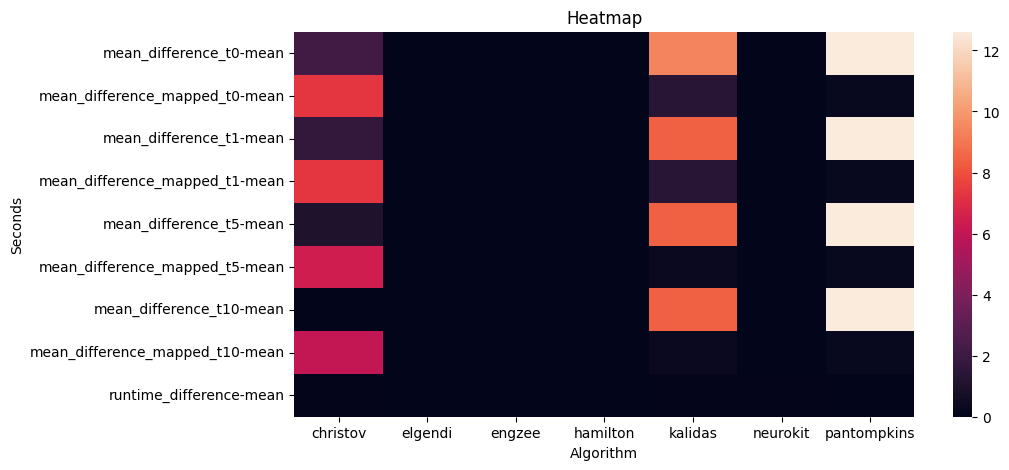

In [21]:
fig = plt.figure(figsize=(10,5))
ax = sns.heatmap(evaluation_overview.transpose())
ax.set(xlabel='Algorithm', ylabel='Seconds')
ax.set_title('Heatmap')
plt.xticks(rotation=0)
plt.show()
fig.savefig('./results/heatmap_total.png')
plt.close()

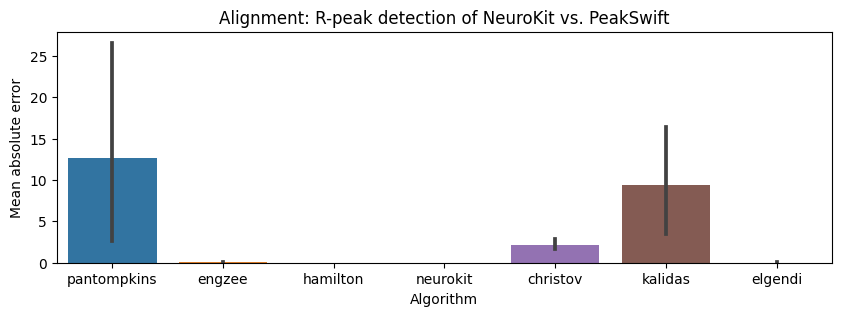

In [22]:
fig = plt.figure(figsize=(10,3))
ax = sns.barplot(data=result_table, x="algorithm", y="mean_difference_t0")
ax.set(xlabel='Algorithm', ylabel='Mean absolute error')
ax.set_title('Alignment: R-peak detection of NeuroKit vs. PeakSwift')
plt.show()
fig.savefig('./results/comparisonRPeak.png', dpi=300)
plt.close()

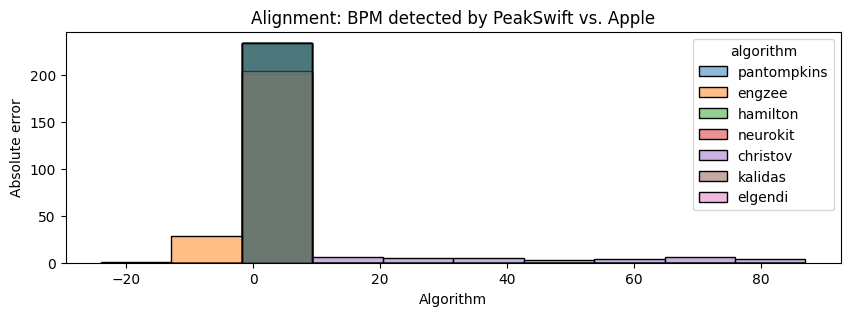

In [27]:
fig = plt.figure(figsize=(10,3))
ax = sns.histplot(data=result_table, x="peak_diff", hue="algorithm", bins=10)
ax.set(xlabel='Algorithm', ylabel='Absolute error')
ax.set_title('Alignment: BPM detected by PeakSwift vs. Apple')
plt.show()
fig.savefig('./results/deviations_number_rpeaks.png', dpi=300)
plt.close()

### Beats per Minute Accuracy
Assessed in a comparison towards FDA approved Apple's BPM rating.

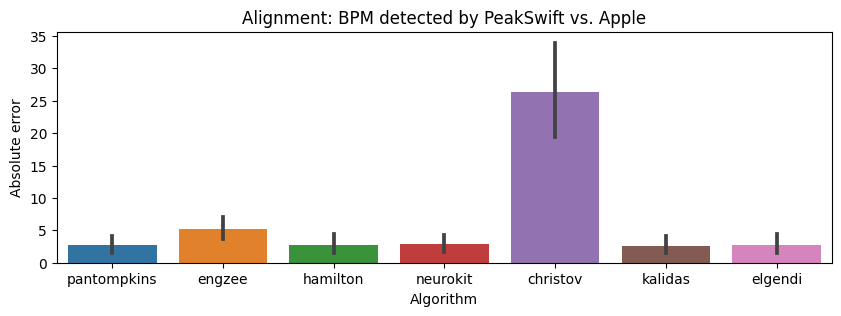

In [24]:
fig = plt.figure(figsize=(10,3))
ax = sns.barplot(data=result_table, x="algorithm", y="bpm_difference")
ax.set(xlabel='Algorithm', ylabel='Absolute error')
ax.set_title('Alignment: BPM detected by PeakSwift vs. Apple')
plt.show()
fig.savefig('./results/comparisonBPM.png', dpi=300)
plt.close()

### Computational Runtime

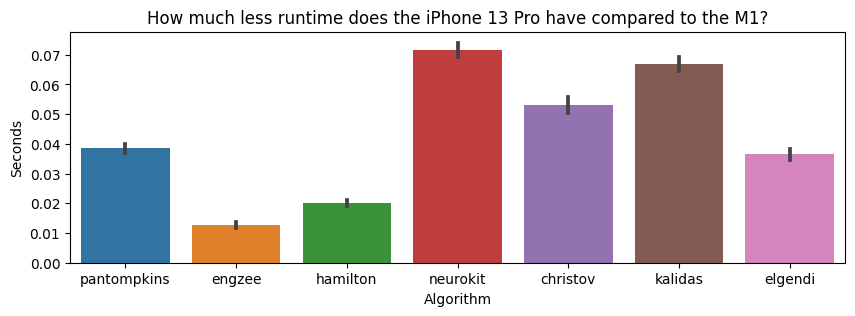

In [25]:
fig = plt.figure(figsize=(10,3))
ax = sns.barplot(data=result_table, x="algorithm", y="runtime_difference")
ax.set(xlabel='Algorithm', ylabel='Seconds')
ax.set_title('How much less runtime does the iPhone 13 Pro have compared to the M1?')
plt.show()
fig.savefig('./results/comparisonRuntime.png', dpi=300)
plt.close()